<a href="https://colab.research.google.com/github/krishnamoji/Tesis-pregrado/blob/main/cotmaxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A partir del codigo Final2.0 hacemos un limite de imax dependiendo de Energy_cota

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.special import legendre
from scipy.special import sph_harm
from scipy import integrate
from numpy import linalg as lg
import time
!pip install py3nj
import py3nj as nj

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for py3nj: filename=py3nj-0.1.2-cp37-cp37m-linux_x86_64.whl size=102675 sha256=1973657457f7991463c003efc5cda782acfc733a813a17ced4054543f5cf04fc
  Stored in directory: /root/.cache/pip/wheels/dd/e8/bb/9e13947719ac9d5a9191f7d788a5025a377d6d1cb1dd1bd330
Successfully built py3nj


In [3]:
ECM=24.5
INT_INICIAL=-3
INT_FINAL=3
NumPasos=201
maxi=20
maxl=2
maxk=2
Zta=30
ZBe=4
Numeromasicota=64
NumeromasicoBe=10
h=0.4 #factor de reescalamiento para Be_11
Energy_Cota=21 #Cota de energia para que se cumpla la aproximación
a0=Zta*ZBe*1.44/(2*ECM)
ecarac=(197.3*((2*ECM)**(1.5)))/(1.44*Zta*ZBe*np.sqrt(8743.68))
maxilambda=3
t = np.linspace(INT_INICIAL, INT_FINAL, NumPasos)
espaciado = t[1]-t[0]

In [4]:
def Rutherford(a_0,angulo): return a_0**2/(4*np.sin(angulo/2)**4)
#polinomio de Legrenge
def P(x,Lambda): 
  leg = legendre(Lambda)
  return leg(x)
#Wood Saxon
def f(r,R,a): return (1+np.exp((r-R)/a))**(-1)
#Derivada de Wood Saxon
def df(r,R,a): return -np.exp((r-R)/a)/(a*(1+np.exp((r-R)/a))**2)
#En la función para_im se cálcula el parametro de impacto a partir del ángulo de deflexión dado en radianes en la variable angdefle.
def param_im(angdefle): 
  b=angdefle/2.0;
  b=np.tan(b);
  b=1.0/b;
  b*=a0;
  return b;
def Vc(r,Rc):
    K = 4*30*1.44 # K=Zp*Zt*e^2 donde e^2=1.44 MeV fm
    if r<=Rc:  return K*(3*Rc**2-r**2) / (2*Rc**3) #K/Rc
    else:     return K/r
def core(x):
  Vr,Vi,Rr,Ri,av=86.2,43.4,6.77,7.39,0.7 
  Rc=1.25*(10**(1/3)+(64)**(1/3))
  return -Vr*f(x,Rr,av)-1j*Vi*f(x,Ri,av)+Vc(x,Rc) #R**2+r**2+2*R*k*r*x
def fragmento(x):
  Vr,Vi,Rr,Ri,av,Vs,Rs,a_s=5.17,0.31,4.81,4.81,0.67,6.09,5.12,0.53
  return -Vr*f(x,Rr,av)-1j*(Vi*f(x,Ri,av)-4*Vs*a_s*df(x,Rr,av))
def integralcore(R,r,Lambda): #x=cos(angulo) donde el angulo es entre R y r. Se multiplica por el polinomio
  k=-1/11
  F= lambda x:core(np.sqrt(R**2+(k*r)**2+2*R*k*r*x))*P(x,Lambda)# |\vec{R}-k\vec{r}|=raiz(R**2+(k*r)**2-2*R*k*r*x)
  return integrate.romberg(F,-1,1,divmax=8,tol=1.0e-2)
def integralfragmento(R,r,Lambda):#x=cos(angulo) donde el angulo es entre R y r.Se multiplica por el polinomio
  k=10/11
  G= lambda x:fragmento(np.sqrt(R**2+(k*r)**2+2*R*k*r*x))*P(x,Lambda)# |\vec{R}+k\vec{r}|=raiz(R**2+(k*r)**2+2*R*k*r*x)
  return integrate.romberg(G,-1,1,divmax=8,tol=1.0e-2)
def integralV_0(R,Lambda):
  V=integralfragmento(R,0,Lambda)+integralcore(R,0,Lambda)
  return V.real
def U_Lambda(R,r,Lambda): return ((2*Lambda+1)/2)*(integralfragmento(R,r,Lambda)+integralcore(R,r,Lambda)-integralV_0(R,Lambda))

def Be_11(maxi,maxl,maxk,s):
  a,a0,R=0,0.6,2.585
  n=30 # n es el grado del polinomio
  ENERGY=np.zeros((maxi,maxl,maxk))
  EIGE=np.zeros((maxi,maxl, maxk,n))
  coef=maxk
  for l in range(maxl):
    if l<s: MAXK=2*l+1
    else: MAXK=coef
    for m in range(MAXK):
      if l%2==0: Vl=62.52 #MeV
      else: Vl=39.74 #MeV
      J=np.abs(l-s)+m
      spinOrb=0.5*(J*(J+1)-l*(l+1)-s*(s+1))
      Vls=21 #Vls esta en MeV fm^2
      A1,A2=10,1
      C=20.736*(A1+A2)/(A1*A2)
      h=0.4
      [X,W]=np.polynomial.laguerre.laggauss(n)
      T=[]
      for i in range (n): T.append([0]*n)
      V=[]
      for i in range (n): V.append([0]*n)
      H=[]
      for i in range (n): H.append([0]*n)
      for i in range(0,n):
          for j in range(0,n):
              if(i==j):
                  T[i][j]=(1/h**2)*C*((4+(4*n+2)*X[i]-X[i]**2)/(12*X[i]**2))
                  V[i][j]=-Vl*f((X[i]*h),R,a0)+Vls*df((X[i]*h),R,a0)*(1/(X[i]*h))*spinOrb+C*l*(l+1)/((X[i]*h)**2)
                  H[i][j]=T[i][j]+V[i][j]
              else:
                  T[i][j]=(1/h**2)*(-1)**(i-j)*C*(((X[i]+X[j]))/(np.sqrt(X[i]*X[j])*(X[i]-X[j])**2))
                  V[i][j]=0
                  H[i][j]=T[i][j]+V[i][j]
      values, vectors = lg.eig(H) #Calculo de los autovalores y autovectores normalizados
      idx = values.argsort()[::1] #Ordenar los autovalores y autovectores  
      values = values[idx]
      vectors = vectors[:,idx]
      vectors = np.transpose(vectors)
      if (values[0]<-1):
        values=np.delete(values,0,0)
        vectors=np.delete(vectors,0,0)
      if (len(values)>maxi):
        for i in range(maxi):
          ENERGY[i][l][m]=values[i]
          for N in range(30):
            EIGE[i][l][m][N]=vectors[i][N]
      else:
        for i in range(len(values)):
          ENERGY[i][l][m]=values[i]
          for N in range(30):
            EIGE[i][l][m][N]=vectors[i][N]        
  return ENERGY,EIGE
def coefU_Lambda(angdefle,opcion): #Se calcula los coeficientes U_lambda de la suma, donde se registran los valores en un tensor donde los indices so omega(tiempo), i (el r_n) y lambda
  POT=np.zeros((NumPasos,30, maxilambda),dtype=np.complex128)
  [X,W]=np.polynomial.laguerre.laggauss(30)
  parametroIm=param_im(angdefle)
  excentricidad=np.sqrt(1+(parametroIm/a0)**2)
  for Lambda in range(maxilambda):
    for lu in range(NumPasos):
      R=0
      if(opcion==1): #Las opciones son para el RK4
        R=INT_INICIAL+lu*espaciado
        R=a0*((excentricidad*np.cosh(R))+1)
      if(opcion==2):
        R=INT_INICIAL+lu*espaciado+0.5*espaciado
        R=a0*((excentricidad*np.cosh(R))+1)
      if(opcion==3):
        R=INT_INICIAL+lu*espaciado+espaciado
        R=a0*((excentricidad*np.cosh(R))+1)
      for n in range(30):
        POT[lu][n][Lambda]=U_Lambda(R,h*X[n],Lambda)
  return POT

def sph_harm_conj(mu,Lambda,theta,phi): # m,l, theta, phi
  A=sph_harm(mu,Lambda,theta,phi)
  return A.conjugate()
def hat(p): return np.sqrt(1*p+1)
def coeficiente(twol,twolp,twoj,twojp,twos,twom,twomp,twolambd):
  w=np.sqrt(4*np.pi)
  exp=(-1)**((twol+twolp+2*twoj+twos)/2)*(-1)**((twolambd-twom)/2)
  gorro= (w*exp*hat(twol)*hat(twolp)*hat(twoj)*hat(twojp))/hat(twolambd)
  a=nj.wigner3j(twoj,twolambd,twojp,-twom,twom-twomp,twomp)
  b=nj.wigner6j(twol,twoj,twos,twojp,twolp,twolambd)
  c=nj.wigner3j(twol,twolambd,twolp,0,0,0)
  return a*b*c*gorro
def potencial(i,twol,twoj,twos,ip,twolp,twojp,maxlambda,phi,angdefle,lu,POT,t,EIGE,k,kp):
  l,lp=twol/2,twolp/2
  l,lp=int(l),int(lp)
  parametroIm=param_im(angdefle)
  excentricidad=np.sqrt(1+(parametroIm/a0)**2)
  theta=np.arcsin( (np.sqrt(excentricidad**2-1)*np.sinh(t))/(excentricidad*np.cosh(t)+1))
  potencialcom=0+0j
  coef=0+0j
  for Lambda in range(maxlambda):
    intradial=0+0j
    for n in range(30):
      coef=EIGE[i][l][k][n]*EIGE[ip][lp][kp][n]*POT[lu][n][Lambda]
      intradial+=coef
    twoj,twojp=int(twoj),int(twojp)
    for twom in range(-twoj,twoj+2,2):
      for twomp in range(-twojp,twojp+2,2):
        mu=(twom-twomp)/2
        mu=int(mu)
        a=0+0j
        if(mu<=Lambda and mu>=-Lambda):
          a=sph_harm_conj(mu,Lambda,theta,phi)
          K2=coeficiente(twol,twolp,twoj,twojp,1,twom,twomp,2*Lambda)
          a*=K2
          a*=intradial
          potencialcom+=a
        else:
          a=0+0j
          a*=intradial
          potencialcom+=a
  expima=1j**(lp-l)
  return expima*potencialcom

def FunRK4(i,l,k,s,a,cotmaxi,maxl,maxk,angdefle,lu,POT,ENERGY,t,EIGE):
  j=np.abs(l-s)+k
  j*=2
  j=int(j)
  F=0+0j
  if(ENERGY[i][l][k]<Energy_Cota):
    parametroIm=param_im(angdefle)
    excentricidad=np.sqrt(1+(parametroIm/a0)**2)
    exponente=1j*(excentricidad*np.sinh(t)+t)/ecarac
    multi=(-1j)*(excentricidad*np.cosh(t)+1)/(ecarac)
    for ip in range(cotmaxi):
      coef=maxk
      for lp in range(maxl):
        if lp<s: MAXK=2*lp+1
        else: MAXK=coef
        for mp in range(MAXK):
          jp=np.abs(lp-s)+mp
          jp*=2
          jp=int(jp)
          Vo=potencial(i, 2*l, j, 2*s, ip, 2*lp, jp, maxilambda, np.pi/2, angdefle, lu, POT, t, EIGE, k, mp)
          x=ENERGY[i][l][k]-ENERGY[ip][lp][mp]
          x=np.exp(x*exponente)
          G=multi*x*Vo*a[ip][lp][mp]
          F+=G
  return F

In [ ]:
#Hallar el cotmaxi para alguna cote de energia
ENERGY,EIGE=Be_11(maxi,maxl,maxk,1/2)
for i in range (maxi):
  if(ENERGY[i][0][0]<=Energy_Cota):
    cotmaxi=i+1
i,l,j,s=0,0,1/2,1/2
h=espaciado
angulo=60
#for angulo in range(10,100,10):
angdefle=angulo*np.pi/180
AR=coefU_Lambda(angdefle,1) # U(omega_i)
BR=coefU_Lambda(angdefle,2) # U(omega_i + 1/2 h)
CR=coefU_Lambda(angdefle,3) # U(omega_i + h)
a=np.zeros((cotmaxi,maxl, maxk),dtype=np.complex128) #Sera el vector A= (a_{i,l,j})
a[0][0][0]=1
k1=np.zeros((cotmaxi,maxl, maxk),dtype=np.complex128) 
k2=np.zeros((cotmaxi,maxl, maxk),dtype=np.complex128) 
k3=np.zeros((cotmaxi,maxl, maxk),dtype=np.complex128) 
k4=np.zeros((cotmaxi,maxl, maxk),dtype=np.complex128)
for lu in range(NumPasos):
  for i in range(cotmaxi):
    coef=maxk
    for l in range(maxl):
      if l<0: MAXK=2*l+1
      else: MAXK=coef
      for m in range(MAXK):
        k1[i][l][m]=FunRK4(i,l,m,s,a,cotmaxi,maxl,maxk,angdefle,lu,AR,ENERGY,t[lu], EIGE)
  for i in range(cotmaxi):
    coef=maxk
    for l in range(maxl):
      if l<0: MAXK=2*l+1
      else: MAXK=coef 
      for m in range(MAXK):
        k2[i][l][m]=FunRK4(i,l,m,s,a+0.5*h*k1,cotmaxi,maxl,maxk,angdefle,lu,BR,ENERGY,t[lu]+0.5*h, EIGE)
  for i in range(cotmaxi):
    coef=maxk
    for l in range(maxl):
      if l<0: MAXK=2*l+1
      else: MAXK=coef 
      for m in range(MAXK):
        k3[i][l][m]=FunRK4(i,l,m,s,a+0.5*h*k2,cotmaxi,maxl,maxk,angdefle,lu,BR,ENERGY,t[lu]+0.5*h, EIGE)
  for i in range(cotmaxi):
    coef=maxk
    for l in range(maxl):
      if l<0: MAXK=2*l+1
      else: MAXK=coef 
      for m in range(MAXK):
        k4[i][l][m]=FunRK4(i,l,m,s,a,cotmaxi,maxl,maxk,angdefle,lu,CR,ENERGY,t[lu]+h, EIGE)
  a=a+h*(k1+2*k2+2*k3+k4)/6 



In [1]:
conservacion=0
i,l,m=0,1,0
print(a)
for i in range (cotmaxi):
  for l in range (maxl):
    for m in range(maxk):
      abs=np.abs(a[i][l][m].real*a[i][l][m].real+a[i][l][m].imag*a[i][l][m].imag)
      conservacion+=abs
print(conservacion)

NameError: ignored

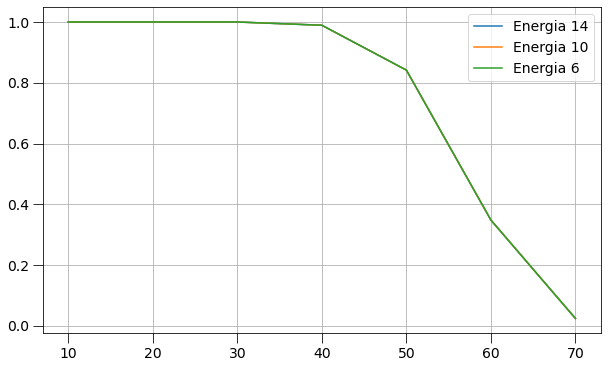

In [ ]:
#Suma de probabilidad (deberian ser 1)
ANGULO=[10,20,30,40,50,60,70]
PROBABILIDAD_14=[1.0000023209891769,1.0000080296774987,0.9999129693390505,0.9892100308828048,0.8416285819038332,0.34809113277442333,0.024285182242899276]
PROBABILIDAD_10=[1.0000022966839444,1.0000079253033056,0.999912758746622,0.9892097016738611,0.8416280419598696,0.34809050920616197,0.02428513064207284]
PROBABILIDAD_6=[1.0000022231515544,1.0000076445702892,0.9999122082779932,0.9892088222381472,0.8416262117166425,0.3480877817288649,0.024284859694405525]

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10 #mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = mpl.rcParams['ytick.minor.size'] = 10 #Lineas 3,4,5 modifican el tamaño de las letras
plt.plot(ANGULO,PROBABILIDAD_14,label=r'Energia 14')
plt.plot(ANGULO,PROBABILIDAD_10,label=r'Energia 10')
plt.plot(ANGULO,PROBABILIDAD_6,label=r'Energia 6')
#plt.title(f'Energia {Energy_Cota} ')
plt.legend()
#plt.ylim(-0.0005,0.0001)
plt.grid(True)
plt.show()

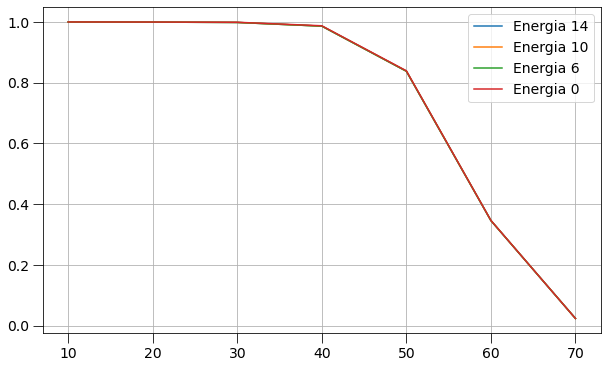

In [ ]:
#coefcientes a[0][0][0] despues del RK4 en varios angulos
ANGULO=[10,20,30,40,50,60,70]
A_14=[9.99967570e-01+7.73618976e-05j,9.99719139e-01+3.62612194e-04j,9.99170096e-01+7.77537809e-04j,9.93096685e-01+1.25111735e-03j,9.15352704e-01+1.73668002e-03j,5.88504169e-01+1.79172999e-03j,1.55474327e-01+7.36198110e-04j ]
A_10=[9.99967558e-01+7.73076555e-05j,9.99719087e-01+3.62220533e-04j,9.99169991e-01+7.76469194e-04j,9.93096520e-01+1.24911783e-03j,9.15352410e-01+1.73391457e-03j,5.88503643e-01+1.78969946e-03j,1.55474165e-01+7.35919761e-04j ]
A_6=[9.99967522e-01+7.70585091e-05j,9.99718947e-01+3.60555329e-04j,9.99169717e-01+7.71959246e-04j,9.93096080e-01+1.24063020e-03j,9.15351416e-01+1.72209912e-03j,5.88501425e-01+1.78121920e-03j ,1.55473599e-01+7.35277835e-04j ]
A_0=[0.99997195+4.06987010e-05j,0.9998134 +1.54108757e-04j,0.99946347+3.19544513e-04j,0.99367262+5.20680151e-04j,0.91611057+0.00077401j,0.58893469+0.00097129j ,0.15544726+0.00052021j ]

for i in range(len(A_14)):
  '''
  A_14[i]=Rutherford(a0,ANGULO[i]*np.pi/180)*np.abs(A_14[i].real*A_14[i].real+A_14[i].imag*A_14[i].imag)
  A_10[i]=Rutherford(a0,ANGULO[i]*np.pi/180)*np.abs(A_10[i].real*A_10[i].real+A_10[i].imag*A_10[i].imag)
  A_6[i]=Rutherford(a0,ANGULO[i]*np.pi/180)*np.abs(A_6[i].real*A_6[i].real+A_6[i].imag*A_6[i].imag)
  A_0[i]=Rutherford(a0,ANGULO[i]*np.pi/180)*np.abs(A_0[i].real*A_0[i].real+A_0[i].imag*A_0[i].imag)
  '''
  A_14[i]=np.abs(A_14[i].real*A_14[i].real+A_14[i].imag*A_14[i].imag)
  A_10[i]=np.abs(A_10[i].real*A_10[i].real+A_10[i].imag*A_10[i].imag)
  A_6[i]=np.abs(A_6[i].real*A_6[i].real+A_6[i].imag*A_6[i].imag)
  A_0[i]=np.abs(A_0[i].real*A_0[i].real+A_0[i].imag*A_0[i].imag)


plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 14})
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10 #mpl.rcParams['xtick.major.width'] = 4
mpl.rcParams['xtick.minor.size'] = mpl.rcParams['ytick.minor.size'] = 10 #Lineas 3,4,5 modifican el tamaño de las letras
plt.plot(ANGULO,A_14,label=r'Energia 14')
plt.plot(ANGULO,A_10,label=r'Energia 10')
plt.plot(ANGULO,A_6,label=r'Energia 6')
plt.plot(ANGULO,A_0,label=r'Energia 0')
#plt.plot(ANGULO,ENERGIA_10,label=r'Energia 10')
#plt.plot(ANGULO,ENERGIA_6,label=r'Energia 6')
#plt.title(f'Energia {Energy_Cota} ')
plt.legend()
#plt.ylim(-0.0005,0.0001)
plt.grid(True)
plt.show()
